### Using the Multi-view Clustering Algorithm to Cluster Data with Multiple Views

In [1]:
from mvlearn.datasets.base import load_UCImultifeature
from mvlearn.cluster.mv_coreg_spectral import MultiviewCoRegSpectralClustering 
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import scipy
import warnings

warnings.simplefilter('ignore') # Ignore warnings
%matplotlib inline
RANDOM_SEED=10

##### Creating a function to display data and the results of clustering

The following function plots both views of data given a dataset and corresponding labels.

In [2]:
def display_plots(pre_title, data, labels):
    
    # plot the views
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    dot_size=10
    ax[0].scatter(data[0][:, 0], data[0][:, 1],c=labels,s=dot_size)
    ax[0].set_title(pre_title + ' View 1')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)

    ax[1].scatter(data[1][:, 0], data[1][:, 1],c=labels,s=dot_size)
    ax[1].set_title(pre_title + ' View 2')
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    plt.show()

##### Performance on moons dataset

For this example, we use the sklearn make_moons function to make two interleaving half circles in two views. We then use spectral clustering to separate the two views. As we can see below, co-regularized multi-view spectral clustering is capable of effectively clustering non-convex cluster shapes, similarly to its single-view analog.

In [3]:
# A function to generate the moons data
def create_moons(seed, num_per_class=500):
    
    np.random.seed(seed)
    data = []
    labels = []
    
    for view in range(2):
        v_dat, v_labs = make_moons(num_per_class*2, 
                random_state=seed + view, noise=0.05, shuffle=False)
        if view == 1:
            v_dat = v_dat[:, ::-1]
        
        data.append(v_dat)
    for ind in range(len(data)):
        labels.append(ind * np.ones(num_per_class,))
    labels = np.concatenate(labels)
    
    return data, labels

In [4]:
# Generating the data
m_data, labels = create_moons(RANDOM_SEED)
n_class = 2

#################Single-view spectral clustering#####################
# Cluster each view separately
s_spectral = SpectralClustering(n_clusters=n_class, 
            affinity='nearest_neighbors', random_state=RANDOM_SEED, n_init=100)
s_clusters_v1 = s_spectral.fit_predict(m_data[0])
s_clusters_v2 = s_spectral.fit_predict(m_data[1])

# Concatenate the multiple views into a single view
s_data = np.hstack(m_data)
s_clusters = s_spectral.fit_predict(s_data)

# Compute nmi between true class labels and single-view cluster labels
s_nmi_v1 = nmi_score(labels, s_clusters_v1)
s_nmi_v2 = nmi_score(labels, s_clusters_v2)
s_nmi = nmi_score(labels, s_clusters)
print('Single-view View 1 NMI Score: {0:.3f}\n'.format(s_nmi_v1))
print('Single-view View 2 NMI Score: {0:.3f}\n'.format(s_nmi_v2))
print('Single-view Concatenated NMI Score: {0:.3f}\n'.format(s_nmi))

#################Multi-view spectral clustering######################

# Use the MultiviewSpectralClustering instance to cluster the data
m_spectral = MultiviewCoRegSpectralClustering(n_clusters=n_class, v_lambda=0.9,
                affinity='nearest_neighbors', max_iter=12, n_neighbors=8,
                random_state=RANDOM_SEED, n_init=100)
m_clusters = m_spectral.fit_predict(m_data)

# Compute nmi between true class labels and multi-view cluster labels
m_nmi = nmi_score(labels, m_clusters)
print('Multi-view NMI Score: {0:.3f}\n'.format(m_nmi))

Single-view View 1 NMI Score: 1.000

Single-view View 2 NMI Score: 1.000

Single-view Concatenated NMI Score: 1.000

Multi-view NMI Score: 0.113



##### Plots of clusters produced by multi-view spectral clustering and the true clusters

We will display the clustering results of the Multi-view spectral clustering algorithm below, along with the true class labels.

<Figure size 432x288 with 0 Axes>

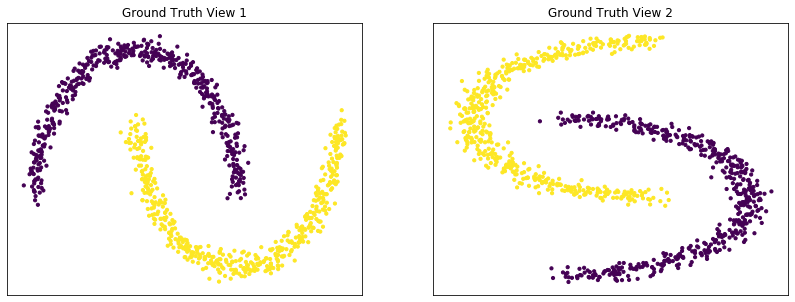

<Figure size 432x288 with 0 Axes>

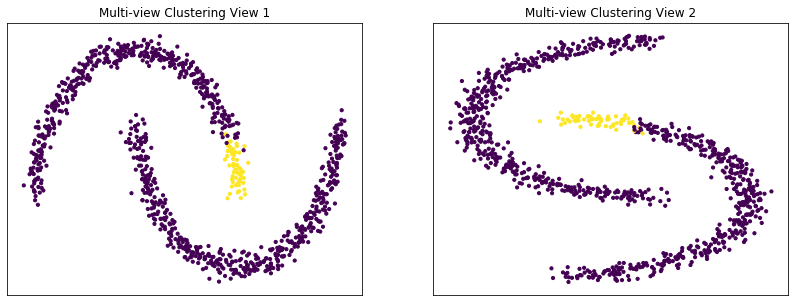

In [5]:
display_plots('Ground Truth' , m_data, labels)
display_plots('Multi-view Clustering' , m_data, m_clusters)

##### Load the UCI Digits Multiple Features Data Set as an Example Data Set

In [6]:
# Load dataset along with labels for digits 0 through 4
n_class = 5
data, labels = load_UCImultifeature(select_labeled = list(range(n_class)))

# Just get the first two views of data
m_data = data[:2]

##### Running Co-Regularized Multi-view Spectral Clustering on the Data with 2 Views
Here we will compare the performance of the Co-Regularized Multi-view and Single-view versions of spectral clustering. We will evaluate the purity of the resulting clusters from each algorithm with respect to the class labels using the normalized mutual information metric. <br>

As we can see, Co-Regularized Multi-view clustering produces clusters with higher purity compared to those produced by Single-view clustering for all 3 input types.

In [7]:
#################Single-view spectral clustering#####################
# Cluster each view separately
s_spectral = SpectralClustering(n_clusters=n_class, random_state=RANDOM_SEED, n_init=100)
s_clusters_v1 = s_spectral.fit_predict(m_data[0])
s_clusters_v2 = s_spectral.fit_predict(m_data[1])

# Concatenate the multiple views into a single view
s_data = np.hstack(m_data)
s_clusters = s_spectral.fit_predict(s_data)

# Compute nmi between true class labels and single-view cluster labels
s_nmi_v1 = nmi_score(labels, s_clusters_v1)
s_nmi_v2 = nmi_score(labels, s_clusters_v2)
s_nmi = nmi_score(labels, s_clusters)
print('Single-view View 1 NMI Score: {0:.3f}\n'.format(s_nmi_v1))
print('Single-view View 2 NMI Score: {0:.3f}\n'.format(s_nmi_v2))
print('Single-view Concatenated NMI Score: {0:.3f}\n'.format(s_nmi))

#######Co-Regularized Multi-view spectral clustering##################

dists1 = scipy.spatial.distance.cdist(m_data[0], m_data[0])
dists2 = scipy.spatial.distance.cdist(m_data[1], m_data[1])
sq_dists1 = np.square(dists1)
sq_dists2 = np.square(dists2)

# Use the MultiviewSpectralClustering instance to cluster the data
m_spectral1 = MultiviewCoRegSpectralClustering(n_clusters=n_class, 
            random_state=RANDOM_SEED, n_init=100)
m_clusters1 = m_spectral1.fit_predict(m_data)

# Compute nmi between true class labels and multi-view cluster labels
m_nmi1 = nmi_score(labels, m_clusters1)
print('Multi-view NMI Score: {0:.3f}\n'.format(m_nmi1))

Single-view View 1 NMI Score: 0.620

Single-view View 2 NMI Score: 0.009

Single-view Concatenated NMI Score: 0.009

Multi-view NMI Score: 0.661



##### Plots of clusters produced by multi-view spectral clustering and the true clusters

We will display the clustering results of the Co-Regularized Multi-view spectral clustering algorithm below, along with the true class labels.



In [8]:
# Running TSNE to display clustering results via low dimensional embedding
tsne = TSNE()
new_data_1 = tsne.fit_transform(m_data[0])
new_data_2 = tsne.fit_transform(m_data[1])
new_data = [new_data_1, new_data_2]

<Figure size 432x288 with 0 Axes>

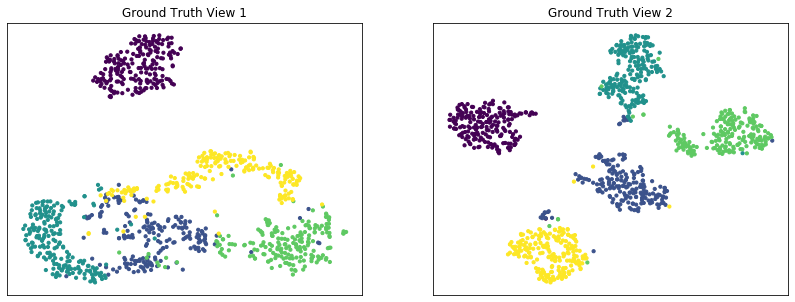

<Figure size 432x288 with 0 Axes>

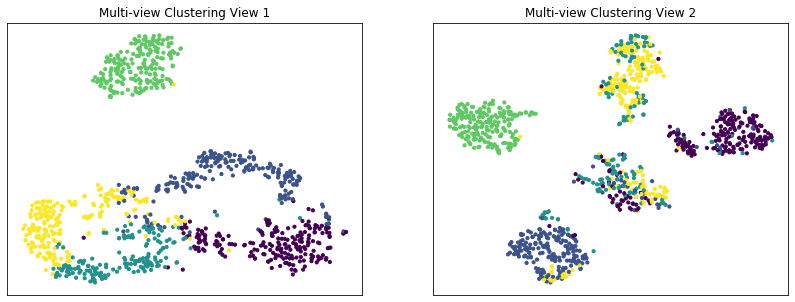

In [9]:
display_plots('Ground Truth' ,new_data, labels)
display_plots('Multi-view Clustering' ,new_data, m_clusters1)